In [1]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.manager import SwarmManager
from backtester.exoinfo import EXOInfo

import pandas as pd
import numpy as np
import scipy

import glob
from pandas.tseries.offsets import *

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## Rng strategies

In [60]:
#
# random time series
#
df = pd.DataFrame()
for i in range(100):
    
    date = pd.date_range(start='2015-01', end='2016-10', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()

## Select input DF. Real swarms or RNG pseudo strategies

In [120]:
# Real swarms
#df = campaign_portfolio

# Rng strategies
#df = df

# Real swarms from csv
#df = pd.read_csv('./swarms_df/ma_cross_swarm_new.csv', parse_dates=[0],
#                dayfirst=True, index_col=0).asfreq(BDay())


# Real swarm from .swm
df = SwarmManager.load('./temp_swarms/EP_BearishCollarBrokenWing_MACross_Long_MA_Cross_Long.swm')
df = df.swarm

In [121]:
df

,"(1, 20, 10, 10)","(1, 20, 10, 12)","(1, 20, 10, 14)","(1, 20, 10, 16)","(1, 20, 10, 18)","(1, 20, 10, 2)","(1, 20, 10, 20)","(1, 20, 10, 22)","(1, 20, 10, 24)","(1, 20, 10, 26)",...,"(1, 90, 20, 28)","(1, 90, 20, 30)","(1, 90, 20, 32)","(1, 90, 20, 34)","(1, 90, 20, 36)","(1, 90, 20, 38)","(1, 90, 20, 4)","(1, 90, 20, 40)","(1, 90, 20, 6)","(1, 90, 20, 8)"
2011-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
#df.dropna().plot(legend=False)

## Systems overall performance estimation

In [123]:
temp_l = []

for strat in df.columns:

        input_strategy_data = df[strat] # This data is used in metrics calc

        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = df[strat].ix[-1] - df[strat].ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        try:
            modsharpe = np.mean(price_change) / np.std(price_change)

        except ZeroDivisionError:
            modsharpe = np.nan

        d = {'strategy': strat,
            'stats_pricechange_modsharpe': modsharpe, 
            'stats_netprofit': netprofit,
            'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
            'stats_profit_factor': profit_factor, 'stats_winrate': winrate }

        temp_l.append(d)      

In [124]:
strategies_performance_df = pd.DataFrame(temp_l).dropna()
strategies_performance_df['rank_score'] = np.zeros_like(len(strategies_performance_df))
strategies_performance_df

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
0,-12488.0,-6663.5,-0.025582,0.863658,-0.533592,10.174419,"(1, 20, 10, 10)",0
1,-13058.0,-4321.0,-0.015147,0.919689,-0.330908,11.264535,"(1, 20, 10, 12)",0
2,-14268.0,-5833.5,-0.020222,0.899783,-0.408852,12.427326,"(1, 20, 10, 14)",0
3,-14663.0,-2396.0,-0.007497,0.963328,-0.163404,13.880814,"(1, 20, 10, 16)",0
4,-12873.0,-388.5,-0.001190,0.994142,-0.030179,14.098837,"(1, 20, 10, 18)",0
5,-5400.5,5501.5,0.026723,1.312834,1.018702,3.997093,"(1, 20, 10, 2)",0
6,-13078.0,-1266.0,-0.003853,0.981925,-0.096804,14.825581,"(1, 20, 10, 20)",0
7,-16628.0,-4698.5,-0.013822,0.939599,-0.282566,16.061047,"(1, 20, 10, 22)",0
8,-16628.0,-8271.0,-0.024056,0.899558,-0.497414,16.642442,"(1, 20, 10, 24)",0
9,-15902.5,-7243.5,-0.020246,0.913864,-0.455494,16.860465,"(1, 20, 10, 26)",0


## Strategies overall performance ranking

In [125]:
ranks_d = {}

for col in strategies_performance_df.columns:
    
    stats_col_flag = False
    
    if 'stats' in col:

        # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
        metric_quantile0 = strategies_performance_df[col].quantile(0.0)
        metric_quantile10 = strategies_performance_df[col].quantile(0.1)
        metric_quantile20 = strategies_performance_df[col].quantile(0.2)
        metric_quantile30 = strategies_performance_df[col].quantile(0.3)
        metric_quantile40 = strategies_performance_df[col].quantile(0.4)
        metric_quantile50 = strategies_performance_df[col].quantile(0.5)
        metric_quantile60 = strategies_performance_df[col].quantile(0.6)
        metric_quantile70 = strategies_performance_df[col].quantile(0.7)
        metric_quantile80 = strategies_performance_df[col].quantile(0.8)
        metric_quantile90 = strategies_performance_df[col].quantile(0.9)
        metric_quantile100 = strategies_performance_df[col].quantile(1)
        
        stats_col_flag = True
    
    if stats_col_flag == True:
        
        for strat in strategies_performance_df.strategy:
        
            # Define strategy statistics rank of certain strategy

            strategy_stats_metric = strategies_performance_df[strategies_performance_df.strategy == strat][col].values[0]

            if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                rank_score = 0

            elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                rank_score = 1

            elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                rank_score = 2

            elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                rank_score = 3

            elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                rank_score = 4

            elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                rank_score = 5

            elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                rank_score = 6

            elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                rank_score = 7

            elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                rank_score = 8

            elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                rank_score = 9

            elif strategy_stats_metric == metric_quantile100:
                rank_score = 10

                
            if strat not in ranks_d.keys():               
                ranks_d[strat] = rank_score
                
            elif strat in ranks_d.keys():                
                ranks_d[strat] = ranks_d[strat] + rank_score
                          
            # For debugging purposes

            #print('strategy---',strat,'\n')
            #print(col)
            #print('10 quantile---',metric_quantile10)
            #print(strategy_stats_metric)
            #print('60 quantile---',metric_quantile60)
            #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
            #print('rank_score------', rank_score, '\n')

        #print("NEXT----------------------- \n")

# Set rank scores for strategies from dict

for k in ranks_d:
    
    strat_index = strategies_performance_df[strategies_performance_df.strategy == k].index
    strategies_performance_df = strategies_performance_df.set_value(strat_index, 'rank_score', ranks_d[k])

In [126]:
strategies_performance_df.sort_values('rank_score', ascending=False)

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
277,-4261.5,6430.5,0.021851,1.146959,1.508976,8.793605,"(1, 40, 12, 40)",53
274,-4983.0,2965.5,0.010577,1.066806,0.595123,8.720930,"(1, 40, 12, 36)",52
417,-4261.5,4619.5,0.016778,1.112259,1.084008,8.502907,"(1, 50, 14, 40)",52
415,-4261.5,2974.5,0.011118,1.073580,0.697994,8.212209,"(1, 50, 14, 38)",52
297,-4110.0,6109.5,0.022850,1.171601,1.486496,7.630814,"(1, 40, 14, 40)",52
273,-5155.5,2793.0,0.009965,1.062920,0.541752,8.648256,"(1, 40, 12, 34)",51
414,-4433.0,2317.0,0.008678,1.057315,0.522671,8.066860,"(1, 50, 14, 36)",51
275,-4983.0,3168.0,0.011550,1.074639,0.635762,8.430233,"(1, 40, 12, 38)",51
267,-5013.0,1050.5,0.004237,1.027917,0.209555,7.703488,"(1, 40, 12, 22)",51
290,-4634.0,2867.0,0.011287,1.080851,0.618688,7.630814,"(1, 40, 14, 28)",51


## Drop all strategies which have rank score less than n quantile value 

In [127]:
df = df[strategies_performance_df[strategies_performance_df.rank_score >= strategies_performance_df.rank_score.quantile(0.5)].strategy]

In [128]:
#df.dropna().plot(legend=False)

## Filter those strategies by correlation

In [129]:
# Rearrange columns from best to worst strategies
df = df.reindex_axis(strategies_performance_df.sort_values('rank_score', ascending=False).strategy, axis=1).dropna(axis=1).asfreq(BDay())

In [130]:
df.corr()

strategy,"(1, 40, 12, 40)","(1, 40, 12, 36)","(1, 50, 14, 40)","(1, 50, 14, 38)","(1, 40, 14, 40)","(1, 40, 12, 34)","(1, 50, 14, 36)","(1, 40, 12, 38)","(1, 40, 12, 22)","(1, 40, 14, 28)",...,"(1, 20, 18, 24)","(1, 70, 12, 34)","(1, 20, 10, 8)","(1, 40, 12, 4)","(1, 20, 14, 14)","(1, 70, 12, 32)","(1, 30, 18, 28)","(1, 40, 10, 2)","(1, 70, 12, 36)","(1, 90, 20, 12)"
strategy,,,,,,,,,,,,,,,,,,,,,
"(1, 40, 12, 40)",1.000000,0.956767,0.899101,0.865744,0.949647,0.952477,0.824290,0.965927,0.880621,0.936590,...,-0.372410,-0.664313,-0.531194,-0.674573,-0.164350,-0.649123,-0.115508,-0.544324,-0.664313,-0.383095
"(1, 40, 12, 36)",0.956767,1.000000,0.800723,0.791672,0.949840,0.999783,0.748406,0.996687,0.912212,0.952218,...,-0.346614,-0.557405,-0.497565,-0.657213,-0.106533,-0.550121,0.075006,-0.574042,-0.557405,-0.375628
"(1, 50, 14, 40)",0.899101,0.800723,1.000000,0.985737,0.750033,0.795229,0.974065,0.817292,0.825820,0.769893,...,-0.195171,-0.698582,-0.444580,-0.519137,-0.080239,-0.663662,-0.420380,-0.370276,-0.698582,-0.338034
"(1, 50, 14, 38)",0.865744,0.791672,0.985737,1.000000,0.702418,0.786056,0.996114,0.806364,0.851447,0.751382,...,-0.081690,-0.638801,-0.360703,-0.436681,0.016078,-0.601767,-0.436682,-0.301479,-0.638801,-0.296297
"(1, 40, 14, 40)",0.949647,0.949840,0.750033,0.702418,1.000000,0.948097,0.646972,0.949096,0.782993,0.960104,...,-0.528012,-0.653961,-0.646859,-0.799783,-0.304945,-0.657177,0.083660,-0.704632,-0.653961,-0.470199
"(1, 40, 12, 34)",0.952477,0.999783,0.795229,0.786056,0.948097,1.000000,0.742532,0.996193,0.911230,0.950201,...,-0.350360,-0.552891,-0.498513,-0.658719,-0.106200,-0.545796,0.086863,-0.577541,-0.552891,-0.374776
"(1, 50, 14, 36)",0.824290,0.748406,0.974065,0.996114,0.646972,0.742532,1.000000,0.761930,0.828732,0.702529,...,-0.027309,-0.614226,-0.325221,-0.380826,0.042092,-0.575082,-0.475475,-0.254469,-0.614226,-0.281769
"(1, 40, 12, 38)",0.965927,0.996687,0.817292,0.806364,0.949096,0.996193,0.761930,1.000000,0.921423,0.954349,...,-0.339810,-0.560633,-0.480409,-0.650886,-0.086153,-0.550098,0.050716,-0.554901,-0.560633,-0.346827
"(1, 40, 12, 22)",0.880621,0.912212,0.825820,0.851447,0.782993,0.911230,0.828732,0.921423,1.000000,0.858390,...,-0.008901,-0.420798,-0.221267,-0.357117,0.192447,-0.395530,-0.088929,-0.251384,-0.420798,-0.124818


In [131]:
corr_df = df.corr()

while_loop_break_flag = False

while True:   
    if while_loop_break_flag == False:
        
        for i in range(len(corr_df)):

            try:       
                strat_corr = corr_df[corr_df.columns[i]]
            
            except IndexError:               
                strat_corr = corr_df[corr_df.columns[i]]
            
            df = df.drop(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index, axis=1)

            # Check if previous DF are the same as current DF
            # If they are different - continue the loop

            df_comparison_array = np.array_equal(corr_df,df.corr())
            
            #print(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index)
            #print(i)
            #print(len(corr_df))
            #print(len(corr_df))
            
            if df_comparison_array  == False and i < len(corr_df):
                corr_df = df.corr()

            elif df_comparison_array  == True and i == len(corr_df)-1:
                while_loop_break_flag = True
                break
                    
    if while_loop_break_flag == True:
        break

In [132]:
df.corr()

strategy,"(1, 40, 12, 40)","(1, 90, 18, 38)","(1, 20, 12, 18)","(1, 40, 16, 2)","(1, 40, 14, 2)","(1, 60, 20, 32)","(1, 60, 16, 4)","(1, 60, 10, 6)","(1, 40, 16, 12)","(1, 20, 16, 2)","(1, 50, 16, 38)","(1, 40, 18, 2)","(1, 60, 12, 2)"
strategy,,,,,,,,,,,,,
"(1, 40, 12, 40)",1.000000,0.381019,0.053149,0.306396,-0.517424,-0.204682,0.291385,0.371144,0.115763,-0.468597,0.493760,-0.323638,-0.260684
"(1, 90, 18, 38)",0.381019,1.000000,0.443224,0.474724,0.063245,0.480180,0.052718,0.278427,0.433334,0.111050,-0.184068,-0.308231,0.272051
"(1, 20, 12, 18)",0.053149,0.443224,1.000000,0.440066,0.479686,0.268702,0.161298,-0.162890,-0.171322,0.039262,-0.131432,-0.195754,0.495308
"(1, 40, 16, 2)",0.306396,0.474724,0.440066,1.000000,0.441455,-0.057279,-0.333620,0.186874,0.463770,-0.141774,-0.425189,-0.267713,-0.082400
"(1, 40, 14, 2)",-0.517424,0.063245,0.479686,0.441455,1.000000,0.152428,-0.328104,-0.366380,0.094846,0.421426,-0.662508,0.166395,0.185321
"(1, 60, 20, 32)",-0.204682,0.480180,0.268702,-0.057279,0.152428,1.000000,0.134650,0.121769,0.196978,0.370880,-0.074445,-0.180865,0.344733
"(1, 60, 16, 4)",0.291385,0.052718,0.161298,-0.333620,-0.328104,0.134650,1.000000,-0.015588,-0.466728,-0.254633,0.495014,0.032694,0.293404
"(1, 60, 10, 6)",0.371144,0.278427,-0.162890,0.186874,-0.366380,0.121769,-0.015588,1.000000,0.306285,-0.376215,0.227724,-0.267457,-0.019581
"(1, 40, 16, 12)",0.115763,0.433334,-0.171322,0.463770,0.094846,0.196978,-0.466728,0.306285,1.000000,0.266996,-0.465238,-0.037590,-0.215790


In [ ]:
df.dropna().plot(legend=False)

In [ ]:
df.dropna().plot(legend=False)

# Metrics calculation

In [24]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = monday # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate }
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [25]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [26]:
stats_df

,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy
30,2011-02-07,2011-01-31,6,-204.0,1.106000e+03,5.421214e-01,6.421569,5.421569e+00,40.000000,"(1, 10, 5, 6)"
34,2011-02-07,2011-01-31,6,-204.0,3.296000e+03,7.662575e-01,17.156863,1.615686e+01,60.000000,"(1, 10, 5, 9)"
36,2011-02-14,2011-02-07,7,-204.0,1.106000e+03,5.421214e-01,6.421569,5.421569e+00,40.000000,"(1, 10, 5, 6)"
40,2011-02-14,2011-02-07,7,-204.0,3.296000e+03,7.662575e-01,17.156863,1.615686e+01,60.000000,"(1, 10, 5, 9)"
42,2011-02-21,2011-02-14,8,-204.0,1.106000e+03,5.421214e-01,6.421569,5.421569e+00,40.000000,"(1, 10, 5, 6)"
46,2011-02-21,2011-02-14,8,-204.0,3.296000e+03,7.662575e-01,17.156863,1.615686e+01,60.000000,"(1, 10, 5, 9)"
48,2011-02-28,2011-02-21,9,-664.0,-4.440000e+02,-2.892190e-01,0.447761,-6.686747e-01,40.000000,"(1, 10, 5, 6)"
52,2011-02-28,2011-02-21,9,-664.0,-4.440000e+02,-2.892190e-01,0.447761,-6.686747e-01,40.000000,"(1, 10, 5, 9)"
54,2011-03-07,2011-02-28,10,-1210.0,-1.210000e+03,-9.065769e-01,0.090226,-1.000000e+00,20.000000,"(1, 10, 5, 6)"
58,2011-03-07,2011-02-28,10,-1210.0,-1.210000e+03,-9.065769e-01,0.090226,-1.000000e+00,20.000000,"(1, 10, 5, 9)"


## Statistics rank calculation

In [27]:
ranks_d = {}
ranks_rebidx_d = {}

for i in stats_df.rebalance_index.unique():

    for col in stats_df[stats_df.rebalance_index == i].columns:
        
        stats_col_flag = False
    
        if 'stats' in col:

            # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
            metric_quantile0 = stats_df[col].quantile(0.0)
            metric_quantile10 = stats_df[col].quantile(0.1)
            metric_quantile20 = stats_df[col].quantile(0.2)
            metric_quantile30 = stats_df[col].quantile(0.3)
            metric_quantile40 = stats_df[col].quantile(0.4)
            metric_quantile50 = stats_df[col].quantile(0.5)
            metric_quantile60 = stats_df[col].quantile(0.6)
            metric_quantile70 = stats_df[col].quantile(0.7)
            metric_quantile80 = stats_df[col].quantile(0.8)
            metric_quantile90 = stats_df[col].quantile(0.9)
            metric_quantile100 = stats_df[col].quantile(1)

            stats_col_flag = True

        if stats_col_flag == True:
    
            for strat in stats_df[stats_df.rebalance_index == i].strategy:

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                    rank_score = 0

                elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                    rank_score = 1

                elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                    rank_score = 2

                elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                    rank_score = 3

                elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                    rank_score = 4

                elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                    rank_score = 5

                elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                    rank_score = 6

                elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                    rank_score = 7

                elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                    rank_score = 8

                elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                    rank_score = 9

                elif strategy_stats_metric == metric_quantile100:
                    rank_score = 10

                    
                if strat not in ranks_d.keys():               
                    ranks_d[strat] = rank_score
                    
                elif strat in ranks_d.keys():                
                    ranks_d[strat] = ranks_d[strat] + rank_score
            #ranks_d['rebalance_idx_'+str(i)] = i

                    
                # For debugging purposes

                #print('strategy---',strat,'\n')
                #print(col)
                #print('10 quantile---',metric_quantile10)
                #print(strategy_stats_metric)
                #print('60 quantile---',metric_quantile60)
                #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
                #print('rank_score------', rank_score, '\n')

    
    print('rebalance index ---', i)
    #break
    for k in ranks_d:

        strat_index = stats_df[(stats_df.strategy == k) & ((stats_df.rebalance_index == i))].index
        #print(strat_index)
        stats_df = stats_df.set_value(strat_index, 'rank_score', ranks_d[k])
        
    ranks_d = {}

rebalance index --- 6
rebalance index --- 7
rebalance index --- 8
rebalance index --- 9
rebalance index --- 10
rebalance index --- 11
rebalance index --- 12
rebalance index --- 13
rebalance index --- 14
rebalance index --- 15
rebalance index --- 16
rebalance index --- 17
rebalance index --- 18
rebalance index --- 19
rebalance index --- 20
rebalance index --- 21
rebalance index --- 22
rebalance index --- 23
rebalance index --- 24
rebalance index --- 25
rebalance index --- 26
rebalance index --- 27
rebalance index --- 28
rebalance index --- 29
rebalance index --- 30
rebalance index --- 31
rebalance index --- 32
rebalance index --- 33
rebalance index --- 34
rebalance index --- 35
rebalance index --- 36
rebalance index --- 37
rebalance index --- 38
rebalance index --- 39
rebalance index --- 40
rebalance index --- 41
rebalance index --- 42
rebalance index --- 43
rebalance index --- 44
rebalance index --- 45
rebalance index --- 46
rebalance index --- 47
rebalance index --- 48
rebalance index

### Strategies picker

In [28]:
# Trade-by-trade pnl
pnl_df = df.diff()

summary_best_eqty = pd.Series()
summary_worst_eqty = pd.Series()
benchmark_eqty = pd.Series()
# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future reference)
        
        picked_best_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:1]
        
        picked_worst_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-1:]
        
        all_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:]
        
        if len(summary_best_eqty) == 0 and len(summary_worst_eqty) == 0 and len(benchmark_eqty) == 0:
            summary_best_eqty = df[picked_best_strats].ix[start_date : end_date].sum(axis=1)           
            summary_worst_eqty = pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1)
            
            benchmark_eqty = pnl_df[all_strats].ix[start_date : end_date].sum(axis=1)      
            
        else:
            summary_best_eqty = summary_best_eqty.append(pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))
            summary_worst_eqty = summary_worst_eqty.append(pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
            benchmark_eqty = benchmark_eqty.append(pnl_df[all_strats].ix[start_date : end_date].sum(axis=1))
            
        
best_portfolio = summary_best_eqty.cumsum()
worst_portfolio = summary_worst_eqty.cumsum() * -1 # Reversed

summary_portfolio = best_portfolio + worst_portfolio

benchmark_portfolio = benchmark_eqty.cumsum()

## Comparing portfolios stats with benchmark(all strategies equity)

In [29]:
def portfolio_stats(portfolio_ser,label):
    input_data = portfolio_ser # This data is used in metrics calc
                
    price_change = input_data.diff()
    max_dd = (input_data - input_data.expanding().max()).min()
    netprofit = input_data.ix[input_data.index[-1]] - input_data.ix[input_data.index[0]]

    # Since swarm PnL statistics is not trade-by-trade
    # For PF calc I used cumulative values of positive and negatives price changes
    # Same for winrate
    profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

    winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

    modsharpe = np.mean(price_change) / np.std(price_change)

    recovery_factor = netprofit / np.abs(max_dd)

    print('Portfolio name ---', str(label))
    print('\n')
    print('PriceChange Mod. Sharpe', modsharpe)
    print('Netprofit',netprofit)
    print('Max DD', max_dd)
    print('Recovery Factor', recovery_factor)
    print('Profit factor', profit_factor)
    print('Winrate', winrate)

    input_data.plot(kind='area', stacked=False)

Portfolio name --- Best


PriceChange Mod. Sharpe 0.02922084614813684
Netprofit 10096.0
Max DD -5892.0
Recovery Factor 1.71350984386
Profit factor 1.39080281799
Winrate 2.80932456665


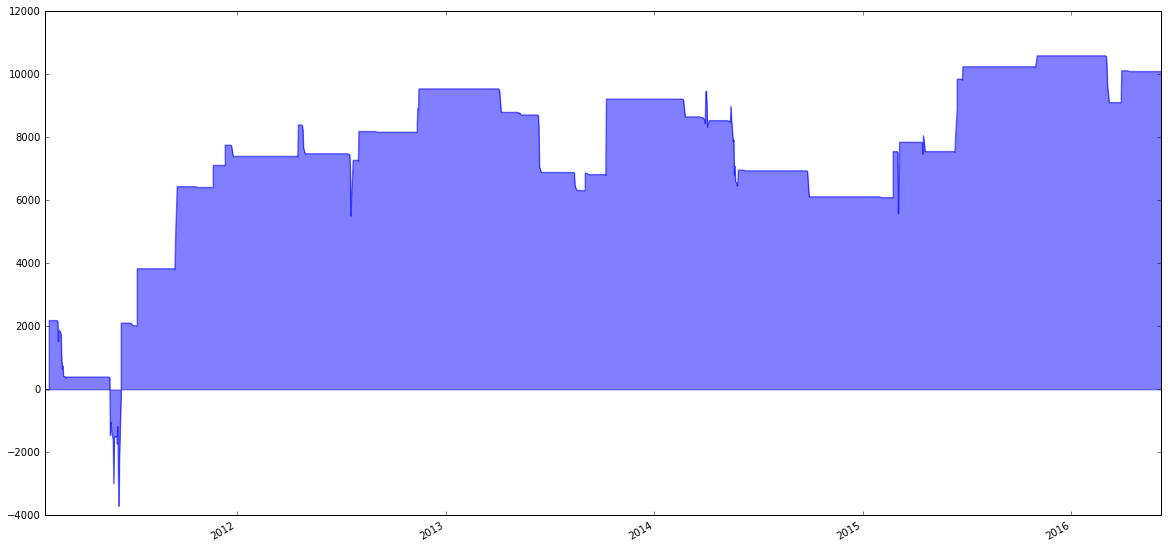

In [30]:
portfolio_stats(best_portfolio, 'Best')

Portfolio name --- Worst(reversed)


PriceChange Mod. Sharpe 0.06332786224309754
Netprofit 50302.0
Max DD -12448.0
Recovery Factor 4.04097043702
Profit factor 1.36843184648
Winrate 23.6102809325


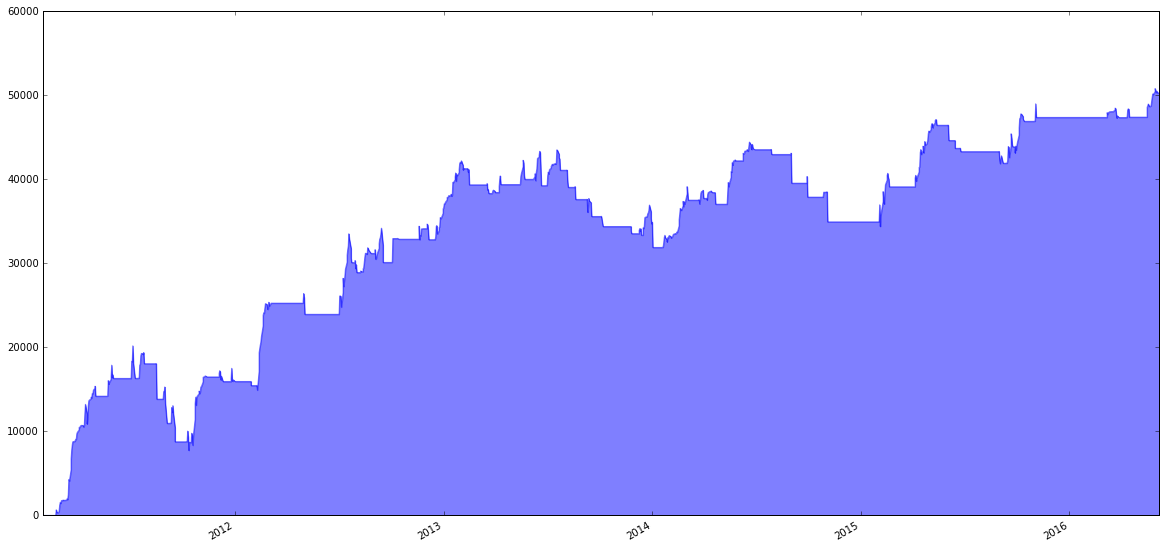

In [31]:
portfolio_stats(worst_portfolio, 'Worst(reversed)')

Portfolio name --- Summary(Best + Worst)


PriceChange Mod. Sharpe 0.07403374527458864
Netprofit 60398.0
Max DD -11272.0
Recovery Factor 5.35823278921
Profit factor 1.44371143109
Winrate 23.2516437537


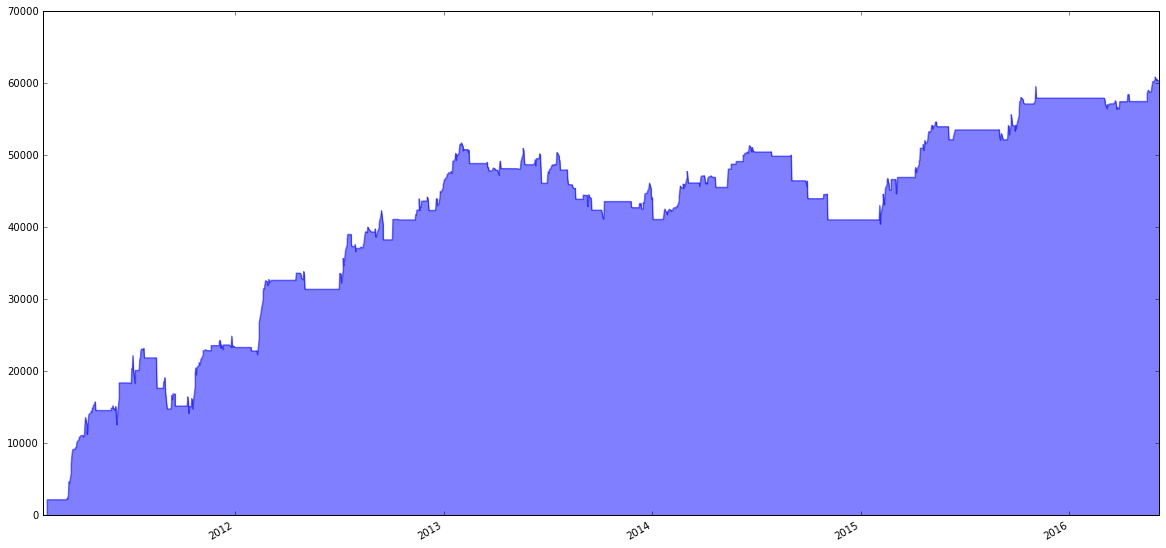

In [32]:
portfolio_stats(summary_portfolio, 'Summary(Best + Worst)')

Portfolio name --- Benchmark


PriceChange Mod. Sharpe 0.0008602227689768382
Netprofit 1906.0
Max DD -41930.0
Recovery Factor 0.0454567135702
Profit factor 1.00374673193
Winrate 19.904363419


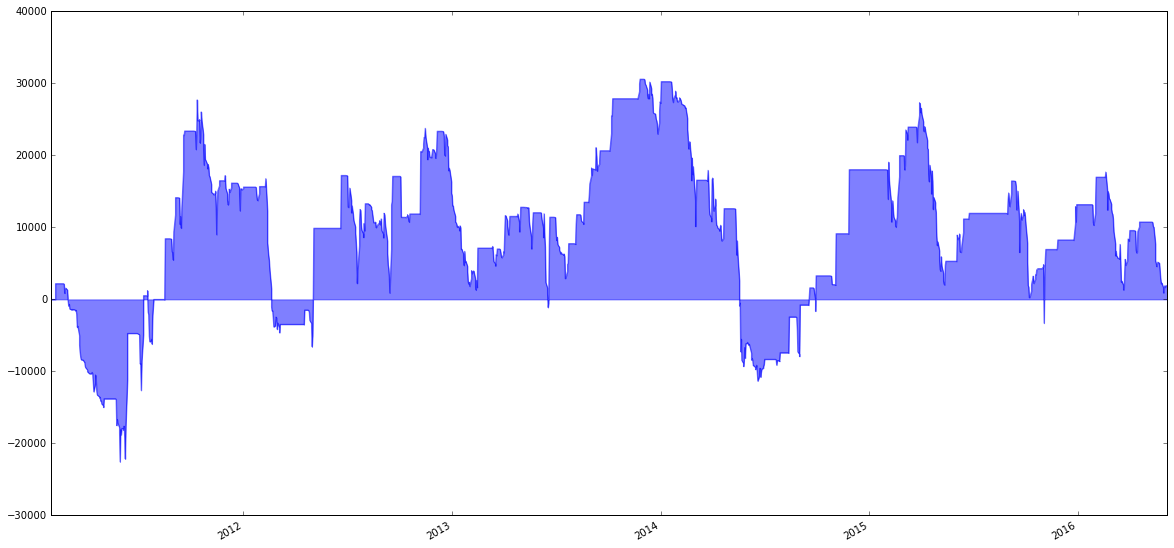

In [33]:
portfolio_stats(benchmark_portfolio, 'Benchmark')